<a href="https://colab.research.google.com/github/carneiro-fernando/EBAC/blob/main/Projetos/Projeto_de_Parceria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O pacote yfinance utiliza uma API para acessar os dados do site Yahoo Finance. >Colocar a fonte<

In [1]:
# Importações da bibliotecas
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Ignora warnings
warnings.filterwarnings('ignore')

## A seguir as empresas do ramo de saúde listadas na B3

In [3]:
# Listando os ativos de saúde
nomes_dos_tickers = ["KRSA3.SA", "MATD3.SA", "ONCO3.SA", "RDOR3.SA", "HAPV3.SA", "ODPV3.SA", "QUAL3.SA", "DASA3.SA"]

# Criando DataFrames com os dados históricos para todos os ativos (doc:https://github.com/ranaroussi/yfinance/wiki/tickers#download)
ticks_df = yf.download(nomes_dos_tickers, period='max', rounding=True, auto_adjust=True)

# Verificando o DataFrame
ticks_df.tail(5)

[*********************100%%**********************]  8 of 8 completed


Close                                                        \
           DASA3.SA HAPV3.SA KRSA3.SA MATD3.SA ODPV3.SA ONCO3.SA QUAL3.SA   
Date                                                                        
2023-11-10    10.02     4.40     0.86     7.20    11.94    10.13     3.09   
2023-11-13    10.03     4.31     0.86     7.40    11.82    10.29     3.01   
2023-11-14    10.55     4.55     0.88     7.61    11.87    10.00     3.16   
2023-11-16    10.40     4.71     0.97     7.90    11.78     9.71     3.10   
2023-11-17    10.16     4.61     0.99     7.45    11.69     9.48     3.07   

                        High           ...     Open            Volume  \
           RDOR3.SA DASA3.SA HAPV3.SA  ... QUAL3.SA RDOR3.SA DASA3.SA   
Date                                   ...                              
2023-11-10    24.63    10.27     4.52  ...     3.11    24.06   614900   
2023-11-13    24.13    10.06     4.45  ...     3.09    24.66   488800   
2023-11-14    25.33    10.74     4.59  ...     3.04    24.30   680800   
2023-11-16    25.89    10.68     4.75  ...     3.17    25.50   449300   
2023-11-17    25.33    10.52     4.75  ...     3.15    25.95   126500   

                                                                    \
               HAPV3.SA   KRSA3.SA  MATD3.SA   ODPV3.SA   ONCO3.SA   
Date                                                                 
2023-11-10   59942200.0   331400.0  359300.0  2385400.0  1408300.0   
2023-11-13   67402900.0   467700.0  344100.0  1019300.0  1754800.0   
2023-11-14  108160000.0  1577300.0  543100.0  2017000.0  7544600.0   
2023-11-16   84165500.0  3523400.0  463800.0  1551400.0  3430200.0   
2023-11-17   25516300.0   407000.0   95400.0   131300.0   925300.0   

                                   
              QUAL3.SA   RDOR3.SA  
Date                               
2023-11-10   7713700.0  3861500.0  
2023-11-13   7221400.0  5932300.0  
2023-11-14  12949100.0  9003900.0  
2023-11-16   9592000.0  5272200.0  
2023-11-17   1703900.0  1225400.0  

[5 rows x 40 columns]

Limpeza

In [4]:
#Verificando se há dados nulos
print(ticks_df.isnull().sum())

Close   DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
High    DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Low     DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Open    DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998
Volume  DASA3.SA       0
        HAPV3.SA    3345
        KRSA3.SA    4161
        MATD3.SA    4096
        ODPV3.SA     519
        ONCO3.SA    4186
        QUAL3.SA    1648
        RDOR3.SA    3998


Descobrindo a data em que entraram na bolsa (IPO)

In [5]:
# Criando um DataFrame com a data da primeira operação registrada no objeto inicializado da API yFinance
data_inicial_df = pd.DataFrame({'Data_inicial': [yf.Ticker(t).history_metadata['firstTradeDate'] for t in nomes_dos_tickers]}, index=nomes_dos_tickers)

# Convertendo o formato de data
data_inicial_df['Data_inicial'] = (pd.to_datetime(data_inicial_df['Data_inicial'], unit='s').dt.date)

# Verificando
data_inicial_df.sort_values(by='Data_inicial')

,Data_inicial
DASA3.SA,2004-11-19
ODPV3.SA,2006-12-01
QUAL3.SA,2011-06-29
HAPV3.SA,2018-04-26
RDOR3.SA,2020-12-15
MATD3.SA,2021-05-13
KRSA3.SA,2021-08-16
ONCO3.SA,2021-09-21


In [6]:
# Verificando se há valores inválidos durante o período de registro de transações para cada ticker.
print('Valores nulos desde o início do registro:\n')

for ticker in data_inicial_df.index:
  data_inicial = data_inicial_df.loc[ticker, 'Data_inicial']

  # Selecionando dentro do índice 'Close' as datas entre o período inicial e o último registro.
  periodo_selecionado = ticks_df['Close'][ticker].loc[data_inicial : ]

  # Imprimindo a soma de valores nulos dentro do período selecionado.
  print(f"Nome: {ticker} | data inicial: {data_inicial} | valores nulos: {periodo_selecionado.isnull().sum()}")

Valores nulos desde o início do registro:

Nome: KRSA3.SA | data inicial: 2021-08-16 | valores nulos: 0
Nome: MATD3.SA | data inicial: 2021-05-13 | valores nulos: 0
Nome: ONCO3.SA | data inicial: 2021-09-21 | valores nulos: 0
Nome: RDOR3.SA | data inicial: 2020-12-15 | valores nulos: 0
Nome: HAPV3.SA | data inicial: 2018-04-26 | valores nulos: 0
Nome: ODPV3.SA | data inicial: 2006-12-01 | valores nulos: 0
Nome: QUAL3.SA | data inicial: 2011-06-29 | valores nulos: 0
Nome: DASA3.SA | data inicial: 2004-11-19 | valores nulos: 0


Analisando os dados numéricos do DataFrame

In [7]:
# Como referencia usaremos sempre o índice 'Close'
ticks_df['Close'].describe()

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
count,4725.000000,1380.000000,564.000000,629.000000,4206.000000,539.000000,3077.000000,727.000000
mean,20.218504,9.036902,2.771223,11.462878,8.072656,8.787885,15.606259,42.976451
std,20.847041,4.030871,1.987194,3.894032,3.903318,2.347187,7.296394,16.732362
min,4.660000,1.940000,0.740000,6.110000,1.080000,4.210000,2.800000,19.840000
25%,9.640000,5.437300,1.070000,8.320000,5.680000,6.780000,10.767100,28.995000
50%,12.870000,8.218950,2.555000,9.720000,7.970000,9.000000,13.763300,34.670000
75%,24.610000,12.410625,3.552500,15.230000,11.487500,10.625000,19.255000,62.300000
max,195.840000,18.151400,8.150000,21.220000,16.090000,15.410000,39.847300,73.300000


Verificamos que:


*   DASA3.SA - É a ação negociada a mais tempo com +4700 registros, confirmando os dados que temos sobre data inicial.
*   RDOR3.SA - Tem o maior valor médio, mais que o dobro da segunda ação com maior valor.
*   KRSA3.SA - Tem o menor média e desvio padrão em termos de valor financeiro, em contraste DASA3.SA tem a maior volatilidade com desvio padrão de ~R$20,00.
*   *Outliers* - A ação DASA3.SA tem uma diferença muito grande entre o terceiro quartil e o valor máximo, indicando possíveis '*outliers*'.




---



Visualização dos dados históricos dos ativos.

Vamos começar por plotar gráficos temporais

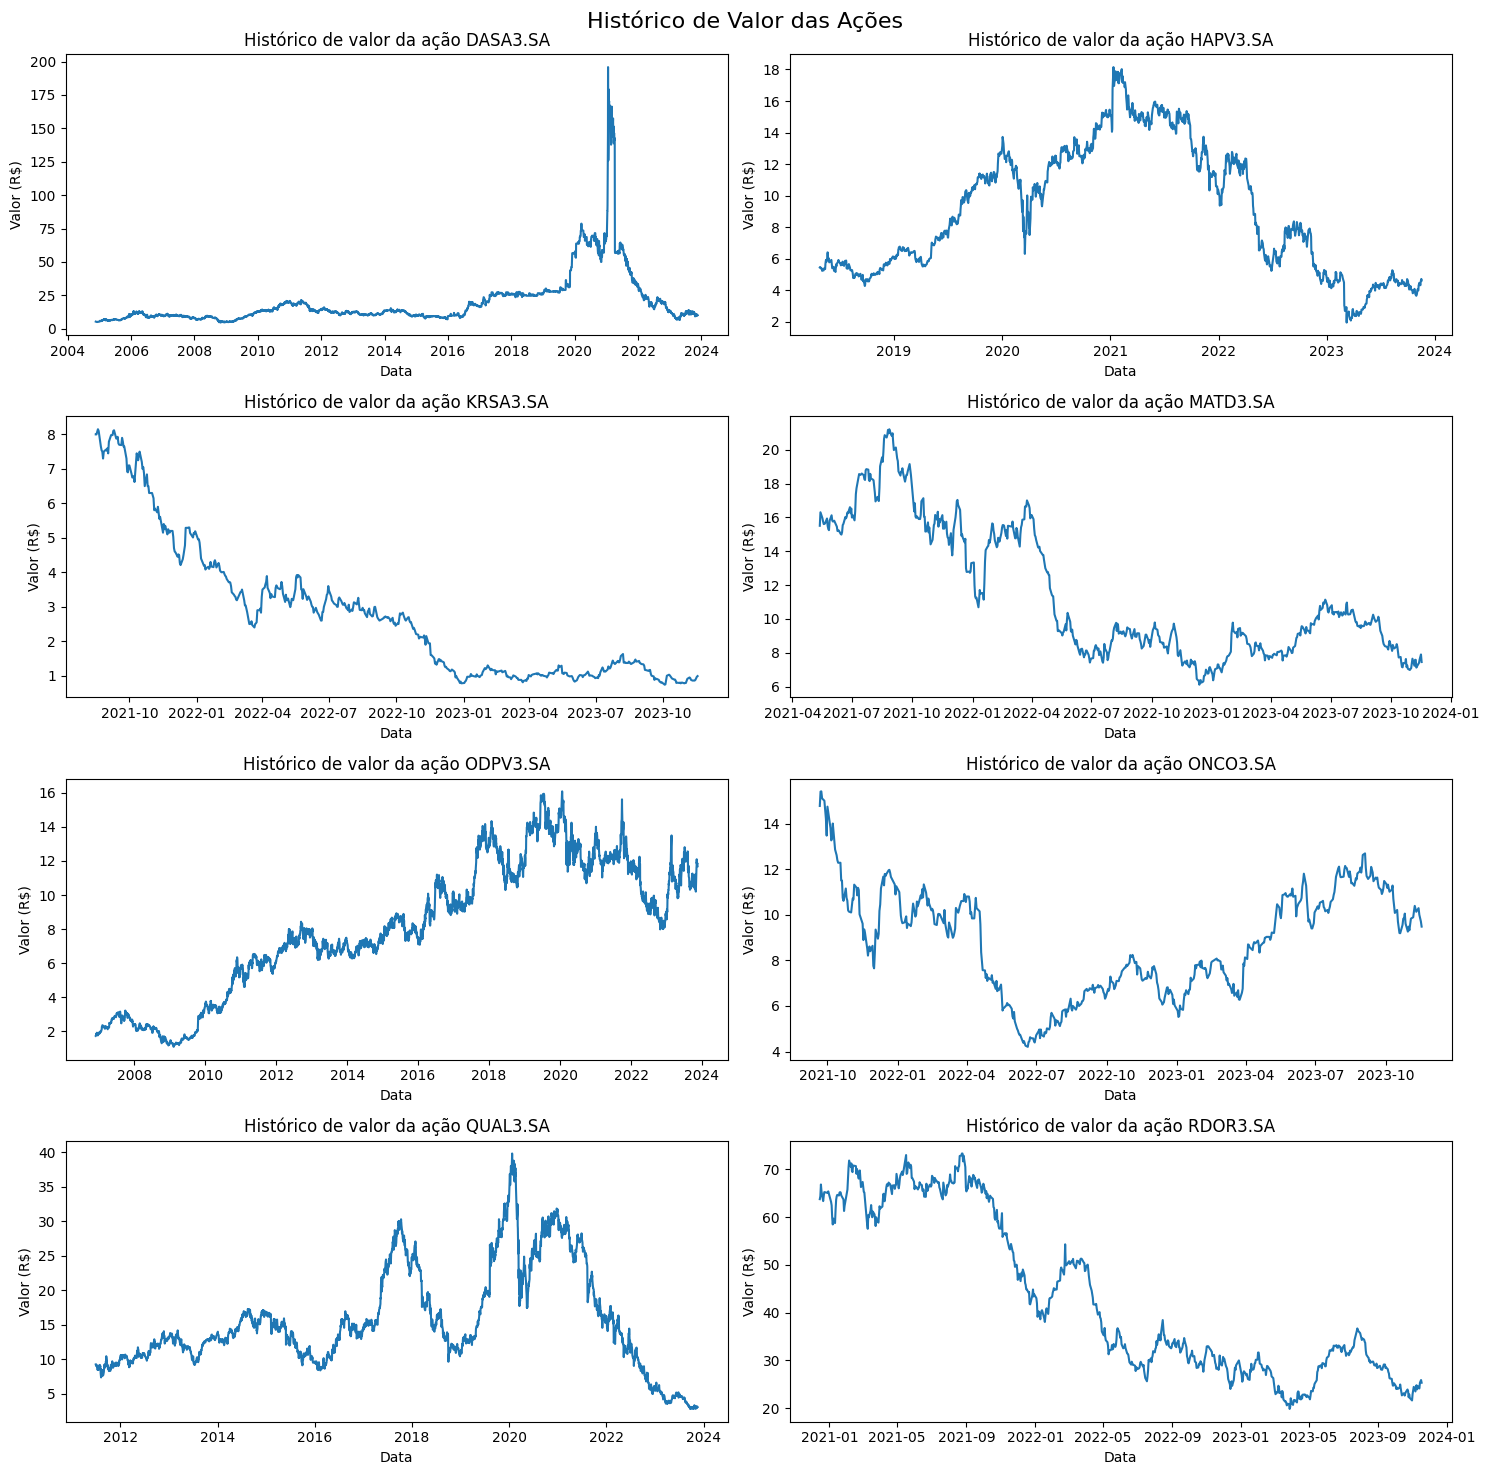

In [8]:
# Criando um grid de gráficos
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig.suptitle("Histórico de Valor das Ações", fontsize=16)

# Laço de repetição que cria os gráficos
for (nome, dados), ax in zip(ticks_df['Close'].items(), axes.ravel()):
    sns.lineplot(x=dados.index, y=dados.values, ax=ax)
    ax.set_title(f'Histórico de valor da ação {nome}')
    ax.set_ylabel('Valor (R$)')
    ax.set_xlabel('Data')

# Ajuste e visualização
plt.tight_layout()
plt.show()

A fim de compraração vamos pegar um período em que haja dados de todas as empresas

In [9]:
# Criando a variável que conterá a data mais recente
data_mais_recente = datetime.date

# Reduzindo a dimensão do DataFrame (transformando o índice de operação em coluna)
unstacked_ticks_df = ticks_df.stack(level=0).rename_axis(['Date', 'Operation'])

# Excluindo todas as linhas com dados não numéricos (NaN) nós chegamos à primeira data comum a todos os ativos
data_mais_recente = unstacked_ticks_df.dropna().index[0][0]

# Verificando
print(f"A data mais recente dentre o primeiro registro dos DataFrames é: {data_mais_recente.date()}")

A data mais recente dentre o primeiro registro dos DataFrames é: 2021-09-21


Vamos selecionar somente o período entre 21 de Setembro de 2021 e a data de registro mais recente:

In [10]:
# Selecionando o período encontrado previamente
ticks_2021_df = ticks_df.loc[data_mais_recente:]

# Conferindo se todos os DataFrames tem o mesmo número de linhas
print({key: df.shape[0] for key, df in ticks_2021_df['Close'].items()})

{'DASA3.SA': 539, 'HAPV3.SA': 539, 'KRSA3.SA': 539, 'MATD3.SA': 539, 'ODPV3.SA': 539, 'ONCO3.SA': 539, 'QUAL3.SA': 539, 'RDOR3.SA': 539}


Restringindo os dados a somente os registros de fechamento ('Close'), que iremos efetivamente usar.

In [11]:
close_2021_df = pd.DataFrame(ticks_2021_df['Close'], columns= ticks_2021_df['Close'].columns)
close_2021_df

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
Date,,,,,,,,
2021-09-21,44.96,15.1600,7.90,18.32,13.00,14.77,20.7316,67.67
2021-09-22,45.15,14.5707,7.80,18.51,13.34,15.40,20.3943,67.20
2021-09-23,44.74,14.8703,7.65,18.52,13.33,15.41,20.4232,67.89
2021-09-24,45.61,14.7205,7.65,18.71,14.32,15.10,20.2401,67.40
2021-09-27,44.73,14.4509,7.30,19.16,14.44,15.00,20.1533,66.15
...,...,...,...,...,...,...,...,...
2023-11-10,10.02,4.4000,0.86,7.20,11.94,10.13,3.0900,24.63
2023-11-13,10.03,4.3100,0.86,7.40,11.82,10.29,3.0100,24.13
2023-11-14,10.55,4.5500,0.88,7.61,11.87,10.00,3.1600,25.33


Agora podemos fazer análises comparativas entre os ativos

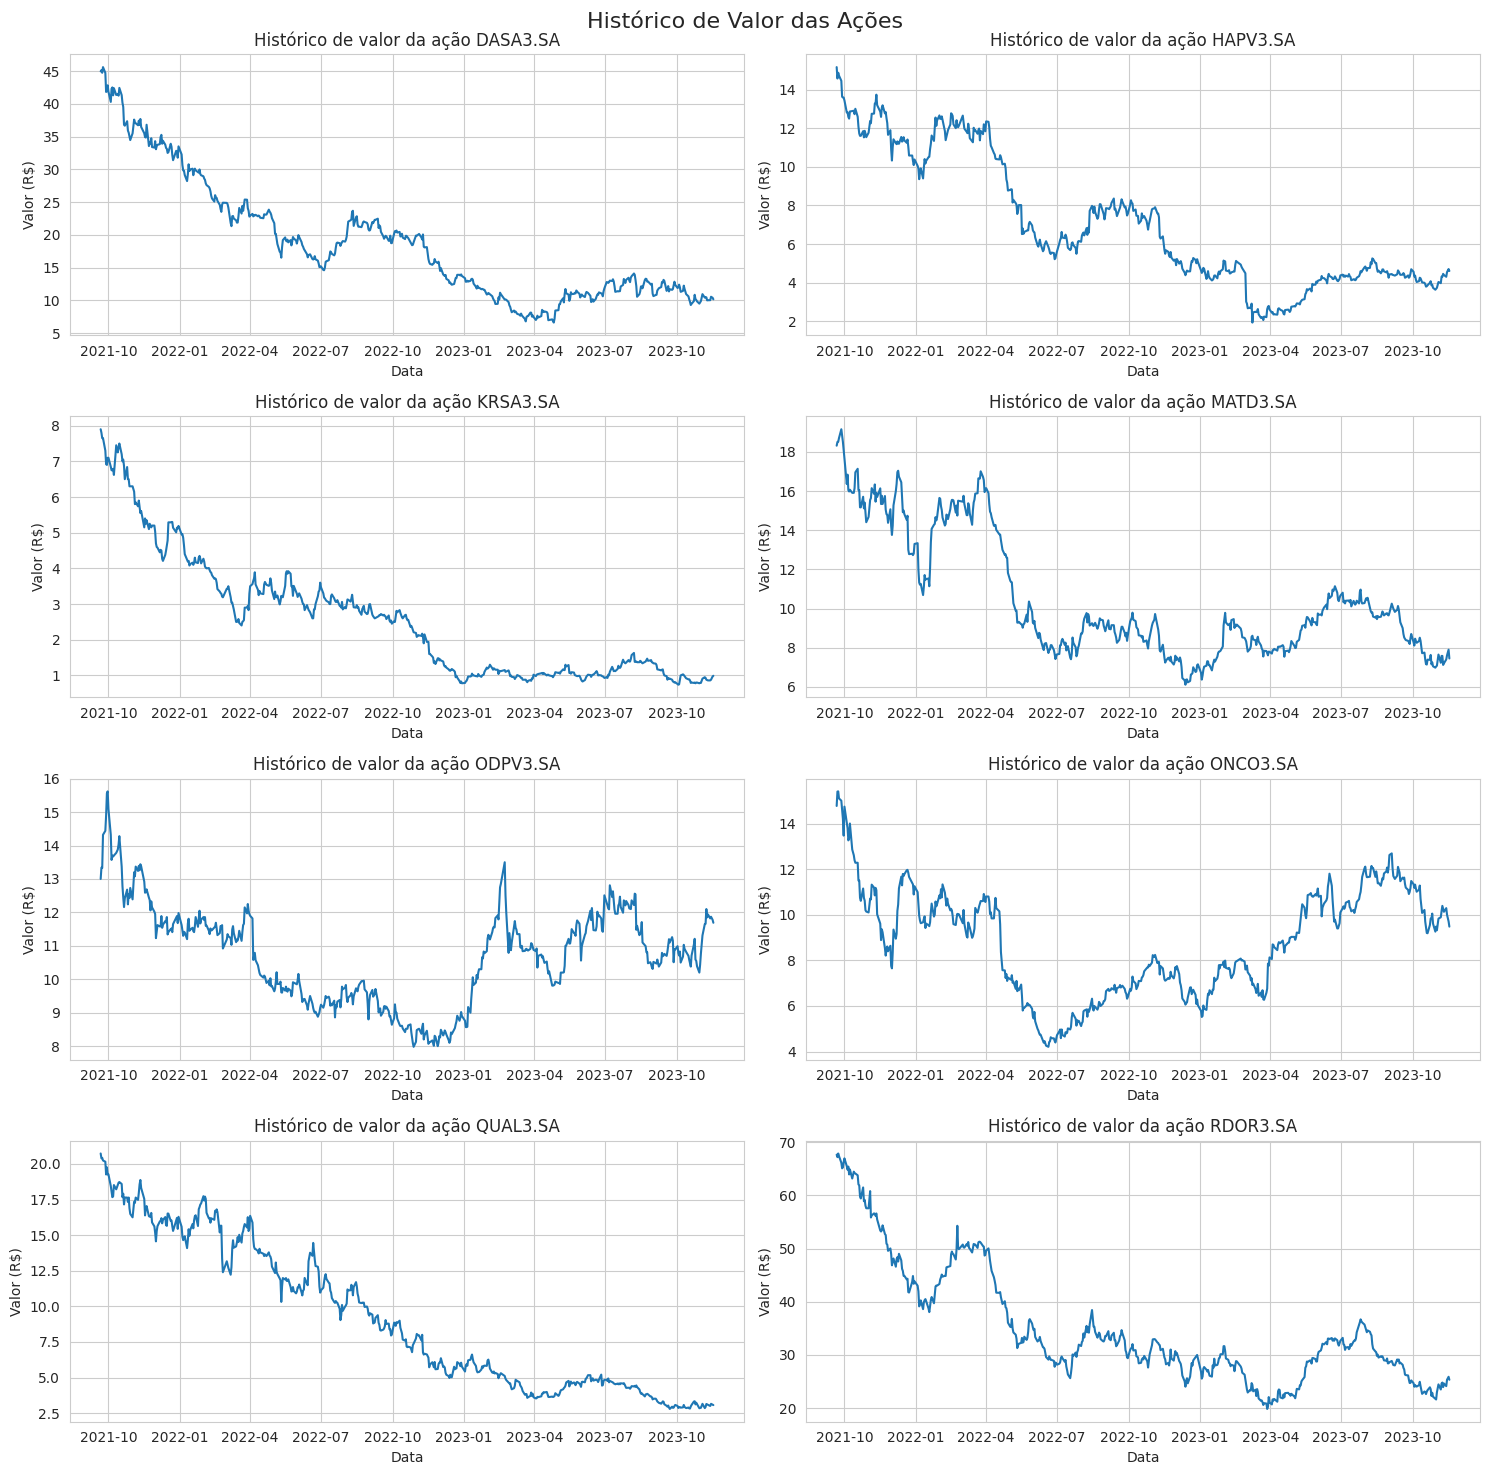

In [12]:
with sns.axes_style(style='whitegrid'):
  fig, axes = plt.subplots(4, 2, figsize=(15, 15))
  fig.suptitle("Histórico de Valor das Ações", fontsize=16)

  # Laço de repetição que cria os gráficos
  for (nome, dados), ax in zip(close_2021_df.items(), axes.ravel()):
      sns.lineplot(x=dados.index, y=dados.values, ax=ax)
      ax.set_title(f'Histórico de valor da ação {nome}')
      ax.set_ylabel('Valor (R$)')
      ax.set_xlabel('Data')

  plt.tight_layout()
  plt.show()

Vamos fazer uma correlação entre as ações e descobrir se há relação entre elas.

In [13]:
# Reseta o índice do DataFrame e calcula a correlação de Pearson entre os ativos
close_2021_df = close_2021_df.reset_index()
corr_df = close_2021_df.corr(method='pearson', numeric_only=True)
corr_df

,DASA3.SA,HAPV3.SA,KRSA3.SA,MATD3.SA,ODPV3.SA,ONCO3.SA,QUAL3.SA,RDOR3.SA
DASA3.SA,1.000000,0.933885,0.961052,0.821330,0.394360,0.305942,0.923666,0.912379
HAPV3.SA,0.933885,1.000000,0.880309,0.880046,0.364116,0.300223,0.936779,0.919183
KRSA3.SA,0.961052,0.880309,1.000000,0.771049,0.380640,0.227533,0.931268,0.873269
MATD3.SA,0.821330,0.880046,0.771049,1.000000,0.668729,0.586186,0.811172,0.935274
ODPV3.SA,0.394360,0.364116,0.380640,0.668729,1.000000,0.746066,0.316188,0.578981
ONCO3.SA,0.305942,0.300223,0.227533,0.586186,0.746066,1.000000,0.127942,0.467907
QUAL3.SA,0.923666,0.936779,0.931268,0.811172,0.316188,0.127942,1.000000,0.870927
RDOR3.SA,0.912379,0.919183,0.873269,0.935274,0.578981,0.467907,0.870927,1.000000


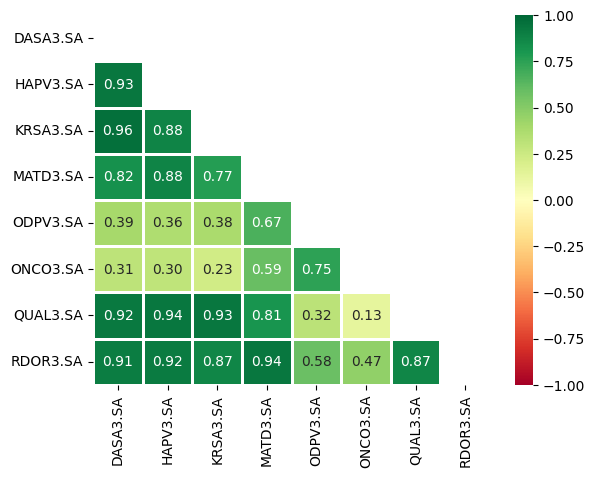

In [14]:
# Criando um numpy array identico (like) a corr_df e preenchido com zeros
mask = np.zeros_like(corr_df)

# Função do pacote NumPy que dado um array ou matriz (quadrada), seleciona a parte triângular superior.
mask[np.triu_indices_from(mask)] = True

# Gerando gráfico
sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2, annot=True, fmt=".2f")
plt.xticks(rotation=90)
plt.show()

Vamos separar os tickers que temos em dois setores: Planos de Saúde e Hospitais:

In [15]:
# Criando um DataFrame com os ativos de planos de saúde e hospitais
ticks_plano_saude_df = close_2021_df[['Date', 'HAPV3.SA', 'ODPV3.SA', 'QUAL3.SA', 'DASA3.SA']]
ticks_hospitais_df = close_2021_df[['Date', 'KRSA3.SA', 'MATD3.SA', 'ONCO3.SA', 'RDOR3.SA']]

ticks_plano_saude_df.head(4)

,Date,HAPV3.SA,ODPV3.SA,QUAL3.SA,DASA3.SA
0,2021-09-21,15.1600,13.00,20.7316,44.96
1,2021-09-22,14.5707,13.34,20.3943,45.15
2,2021-09-23,14.8703,13.33,20.4232,44.74
3,2021-09-24,14.7205,14.32,20.2401,45.61


In [16]:
ticks_hospitais_df.head(4)

,Date,KRSA3.SA,MATD3.SA,ONCO3.SA,RDOR3.SA
0,2021-09-21,7.90,18.32,14.77,67.67
1,2021-09-22,7.80,18.51,15.40,67.20
2,2021-09-23,7.65,18.52,15.41,67.89
3,2021-09-24,7.65,18.71,15.10,67.40


In [17]:
# Criando DataFrames com dados de correlação
corr_planos_df = ticks_plano_saude_df.corr(method='pearson', numeric_only=True)
corr_hospitais_df = ticks_hospitais_df.corr(method='pearson', numeric_only=True)
corr_planos_df.head().reset_index().columns.name = None
corr_hospitais_df.head().reset_index().columns.name = None

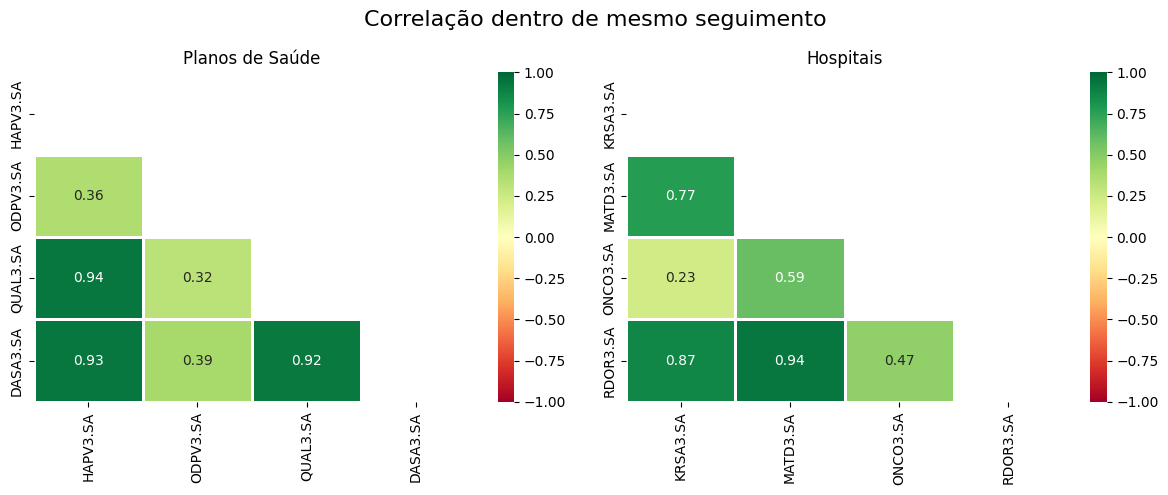

In [18]:
# Criando gráfico de correlação para os planos de saúde e hospitais
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Correlação dentro de mesmo seguimento", fontsize=16)

# Criando um numpy array identico (like) a corr_df e preenchido com zeros
mask_segmentos = np.zeros_like(corr_planos_df)
mask_segmentos[np.triu_indices_from(mask_segmentos)] = True

# Mapa de calor para corr_planos_df
sns.heatmap(corr_planos_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask_segmentos, linewidths=2, annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Planos de Saúde")

# Mapa de calor para corr_hospitais_df
sns.heatmap(corr_hospitais_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask_segmentos, linewidths=2, annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Hospitais")

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

Vamos verificar a correlação com um benchmark da B3 chamado Ibovespa

In [19]:
# Extrai o histórico de preços de fechamento (Close) do IBOVESPA
ibovespa_ticker = yf.Ticker('^BVSP')
ibov_df = ibovespa_ticker.history(start=data_mais_recente)
ibov_df = ibov_df[['Close']]
ibov_df = ibov_df.set_index(pd.to_datetime(ibov_df.index.date)).rename(columns={'Close':'Valores'})

In [20]:
# Criando um DataFrame para armazenar as correlações
ibov_corr = pd.DataFrame(columns=['Ticker', 'Correlacao'])

# Laço de repetição que calcula a correlação entre o IBOV e cada ativo
for t in close_2021_df.iloc[:,1:]:
  correlation = np.corrcoef(close_2021_df[t], ibov_df['Valores'])
  ibov_corr = pd.concat([ibov_corr, pd.DataFrame({'Ticker': [t], 'Correlacao': [np.round(correlation[0][1], 2)]})], ignore_index=True)

ibov_corr

,Ticker,Correlacao
0,DASA3.SA,-0.10
1,HAPV3.SA,0.01
2,KRSA3.SA,-0.22
3,MATD3.SA,0.14
4,ODPV3.SA,0.21
5,ONCO3.SA,0.51
6,QUAL3.SA,-0.23
7,RDOR3.SA,0.09


## Machine Learning

In [29]:
class DataPreparation:
    # Inicializa a classe com os parâmetros necessários
    def __init__(self, df, ticker_list, begin_date, end_date, features, target, operation, days_before):
        self.df = df.copy()
        self.transformed_df = df
        self.ticker_list = ticker_list
        self.begin_date = begin_date
        self.end_date = end_date
        self.features = features
        self.target = target
        self.operation = operation
        self.days_before = days_before

    # Transforma o dataframe para o formato longo
    def transform_to_long_format(self):
        self.transformed_df = self.transformed_df.stack(level=0).rename_axis(['Data', 'Operacao']).reset_index()

    # Seleciona as colunas necessárias e remove os valores NA
    def select_columns_and_drop_na(self):
        if self.ticker_list:
            self.transformed_df = self.transformed_df.loc[:, ['Data', 'Operacao', self.target] + self.ticker_list].dropna()
        else:
            self.transformed_df = self.transformed_df.dropna()

    # Transforma o dataframe para o formato largo
    def transform_to_wide_format(self):
        self.transformed_df = self.transformed_df.pivot(index='Data', columns='Operacao')
        self.transformed_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in self.transformed_df.columns]

    # Filtra o dataframe por data
    def filter_by_date(self):
        if self.begin_date:
            self.transformed_df = self.transformed_df[(self.transformed_df.index >= str(self.begin_date))]
        if self.end_date:
            self.transformed_df = self.transformed_df[(self.transformed_df.index<= str(self.end_date))]

    # Adiciona partes da data como colunas separadas
    def add_date_parts(self):
        self.transformed_df['Ano'] = self.transformed_df.index.year
        self.transformed_df['Mes'] = self.transformed_df.index.month
        self.transformed_df['Dia'] = self.transformed_df.index.day
        self.transformed_df['DiaDaSemana'] = self.transformed_df.index.dayofweek

    # Cria a variável alvo
    def create_target_variable(self):
        # Identifica a coluna alvo, cria 'y', remove a coluna alvo e desloca os dados
        target_column = [col for col in self.transformed_df.columns if col.startswith(self.target) and col.endswith(self.operation)]
        self.y = self.transformed_df[target_column][self.days_before:] if self.days_before != 0 else self.transformed_df[target_column]
        self.transformed_df = self.transformed_df.drop(columns=target_column)
        self.transformed_df = self.transformed_df.shift(-self.days_before).dropna()

    # Seleciona as colunas de recursos
    def select_feature_columns(self):
        # Se existem recursos, seleciona as colunas correspondentes
        if self.features:
            selected_columns = [col for col in self.transformed_df.columns if col.endswith(tuple(self.features))]
            self.transformed_df = self.transformed_df[['Ano', 'Mes', 'Dia', 'DiaDaSemana'] + selected_columns]

    # Cria a variável preditora
    def create_predictor_variable(self):
        # Define 'x' como uma cópia do dataframe
        self.x = self.transformed_df.copy()

    # Cria as variáveis x e y
    def create_xy(self):
        # Executa uma série de transformações e cria as variáveis 'x' e 'y'
        self.transform_to_long_format()
        self.select_columns_and_drop_na()
        self.transform_to_wide_format()
        self.filter_by_date()
        self.add_date_parts()
        self.create_target_variable()
        self.select_feature_columns()
        self.create_predictor_variable()

        # Retorna as variáveis 'x' e 'y'
        return self.x, self.y

class ModelTraining:
    # Inicializa a classe com o modelo, dados e tamanho do teste
    def __init__(self, model, x, y, test_size=0.2):
        self.model = model
        self.x = x
        self.y = y
        self.test_size = test_size
        self.y_scaler = StandardScaler()

    # Normaliza os dados
    def normalize_data(self):
        x_scaler = StandardScaler()
        self.x_normalized = pd.DataFrame(x_scaler.fit_transform(self.x), columns=self.x.columns, index=self.x.index)
        self.y_normalized = pd.DataFrame(self.y_scaler.fit_transform(self.y), columns=self.y.columns, index=self.y.index)

    # Divide os dados em treino e teste
    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x_normalized, self.y_normalized, test_size=self.test_size, shuffle=False)

    # Treina o modelo
    def fit_model(self):
        self.model.fit(self.x_train, self.y_train)

    # Faz a previsão
    def predict(self):
        self.predicted_normalized = self.model.predict(self.x_test)

    # Desnormaliza os dados
    def denormalize_data(self):
        self.predicted = pd.DataFrame(self.y_scaler.inverse_transform(self.predicted_normalized), columns=self.y.columns, index=self.x_test.index)
        self.y_test = pd.DataFrame(self.y_scaler.inverse_transform(self.y_test), columns=self.y.columns, index=self.y_test.index)

    # Executa todo o processo de treinamento e previsão
    def train_and_predict(self):
        self.normalize_data()
        self.split_data()
        self.fit_model()
        self.predict()
        self.denormalize_data()
        return self.y_test, self.predicted


In [22]:
# Define os parâmetros
df = ticks_df
ticker_list = ['DASA3.SA', 'HAPV3.SA', 'QUAL3.SA',  'KRSA3.SA', 'MATD3.SA']
features = ['Open', 'Volume','Close']
begin_date = ''
end_date = ''
target = 'RDOR3.SA'
operation = 'Close'
days_before = 7

# Cria uma instância da classe DataPreparation
data_prep = DataPreparation(df, ticker_list, begin_date, end_date, features, target, operation, days_before)

# Usa o método create_xy para preparar os dados
x, y = data_prep.create_xy()

In [23]:
# Define o modelo - treina - faz a previsão
model = LinearRegression()

model_training = ModelTraining(model, x, y)

y_test, predicted = model_training.train_and_predict()

In [35]:
# Cria DataFrame para comparar os valores reais e previstos
compare_df = pd.concat([y_test, predicted], axis=1).dropna()
compare_df = compare_df.set_axis(['Preço_Real', 'Preço_Previsto'], axis=1)

compare_df.head(5)

,Preço_Real,Preço_Previsto
Data,,
2023-06-09,31.98,33.335024
2023-06-12,32.44,32.859890
2023-06-13,32.00,32.911396
2023-06-14,33.08,33.101886
2023-06-15,33.08,33.185205


In [40]:
# Calcula as métricas
mae = metrics.mean_absolute_error(y_test, predicted)
mse = metrics.mean_squared_error(y_test, predicted)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
r2 = metrics.r2_score(y_test, predicted)
cv_scores = cross_val_score(model, x, y, cv=5)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

# Cria um dicionário de dados
data = {'Erro Médio Absoluto (MAE)': mae,
    'Erro Quadrático Médio (MSE)': mse,
    'Raiz do Erro Quadrático Médio (RMSE)': rmse,
    'R2 Score': r2,
    'Média do Score de Validação Cruzada': cv_mean,
    'Desvio Padrão da Validação Cruzada': cv_std}

# Cria um DataFrame a partir do dicionário
metrics_df = pd.DataFrame(data, index=[0]).T.reset_index()
metrics_df = metrics_df.set_axis(['Métrica', 'Score'], axis=1)

metrics_df

,Métrica,Score
0,Erro Médio Absoluto (MAE),0.547549
1,Erro Quadrático Médio (MSE),0.456311
2,Raiz do Erro Quadrático Médio (RMSE),0.675508
3,R2 Score,0.973308
4,Média do Score de Validação Cruzada,0.964120
5,Desvio Padrão da Validação Cruzada,0.031176


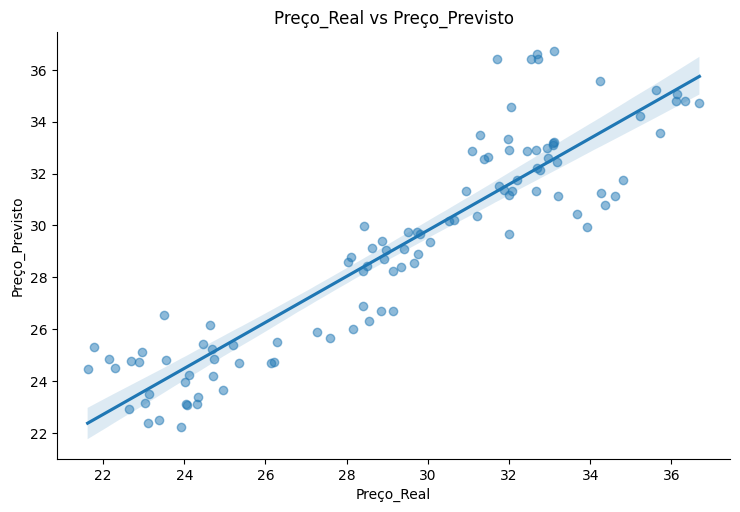

In [26]:
# Plota gráfico de dispersão
sns.lmplot(x='Preço_Real', y='Preço_Previsto', data=compare_df, aspect=1.5, fit_reg=True, scatter_kws={'alpha':0.5})

# Define os rótulos dos eixos e título
plt.xlabel("Preço_Real")
plt.ylabel("Preço_Previsto")
plt.title("Preço_Real vs Preço_Previsto")
plt.show()

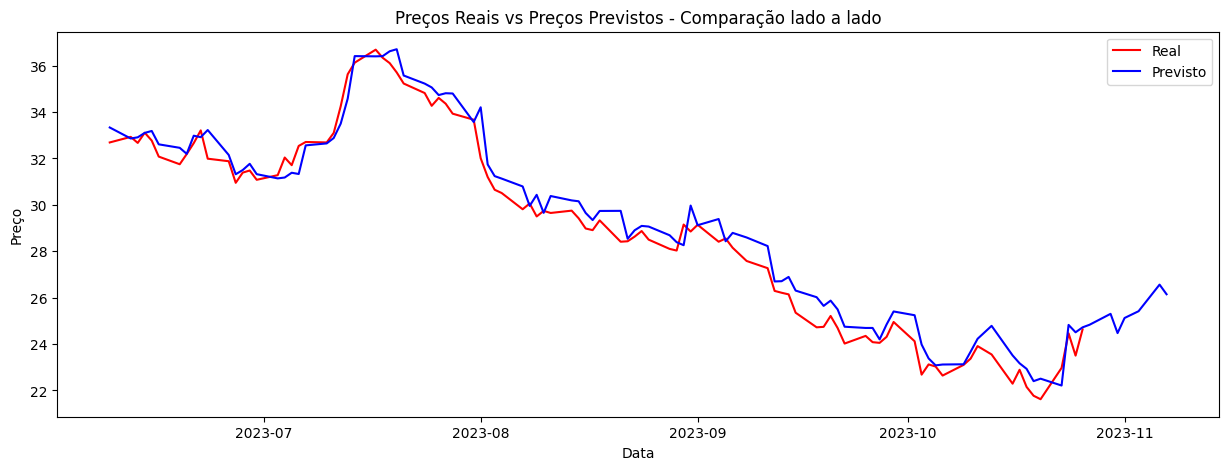

In [27]:
# Cria uma figura e um conjunto de subplots
fig, ax = plt.subplots(figsize=(15,5))

# Plota os valores reais e previstos
ax.plot_date(compare_df.index, compare_df.Preço_Real.shift(-days_before), 'r-', label='Real')
ax.plot_date(compare_df.index, compare_df.Preço_Previsto, 'b-', label='Previsto')

# Define os rótulos, título e legenda
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
ax.set_title('Preços Reais vs Preços Previstos - Comparação lado a lado')
ax.legend()

plt.show()

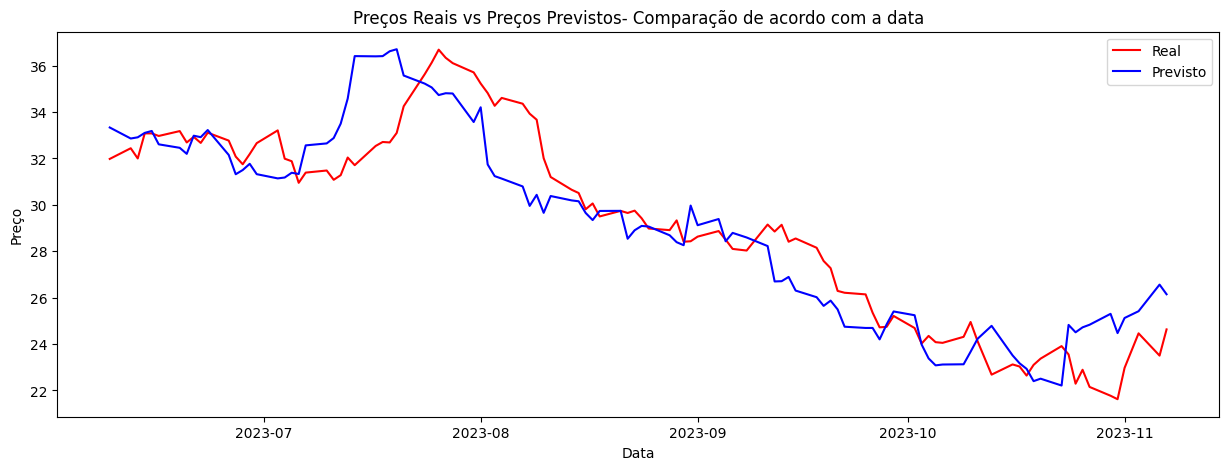

In [37]:
# Cria uma figura e um conjunto de subplots
fig, ax = plt.subplots(figsize=(15,5))

# Plota os dados reais
ax.plot_date(compare_df.index, compare_df.Preço_Real, 'r-', label='Real')

# Plota os dados previstos
ax.plot_date(compare_df.index, compare_df.Preço_Previsto, 'b-', label='Previsto')

# Define os rótulos, título e legenda
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
ax.set_title('Preços Reais vs Preços Previstos- Comparação de acordo com a data')
ax.legend()

plt.show()